In [1]:
pip install mahotas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import mahotas

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pathlib
data_dir=pathlib.Path('/Users/trl102/RadiMax_seg')
Root_imgs_file_name=list(data_dir.glob('Full_experiment_seg/*.png'))

In [5]:
Root_imgs_file_name[0:5]

[PosixPath('/Users/trl102/RadiMax_seg/Full_experiment_seg/Radimax_Cam2_PipeID_296_Position_2151_TS_2018-06-19_16.28.23.244.bdiv.rgb.png'),
 PosixPath('/Users/trl102/RadiMax_seg/Full_experiment_seg/Radimax_Cam4_PipeID_29_Position_3164_TS_2018-06-18_11.45.42.054.bdiv.rgb.png'),
 PosixPath('/Users/trl102/RadiMax_seg/Full_experiment_seg/Radimax_Cam2_PipeID_103_Position_3692_TS_2018-06-18_15.34.17.650.bdiv.rgb.png'),
 PosixPath('/Users/trl102/RadiMax_seg/Full_experiment_seg/Radimax_Cam2_PipeID_268_Position_3622_TS_2018-06-19_15.21.56.789.bdiv.rgb.png'),
 PosixPath('/Users/trl102/RadiMax_seg/Full_experiment_seg/Radimax_Cam3_PipeID_205_Position_2466_TS_2018-06-19_11.39.24.622.bdiv.rgb.png')]

Total Root area: 4396.5
Total Root area: 1053.5
Total Root area: 2137.0
Total Root area: 7169.0
Total Root area: 7188.5
Total Root area: 10270.0
Total Root area: 7930.0
Total Root area: 30765.0
Total Root area: 21237.5
Total Root area: 25766.0
Total Root area: 4574.0
Total Root area: 4561.5
Total Root area: 6521.0
Total Root area: 10697.5
Total Root area: 2461.5
Total Root area: 8291.0
Total Root area: 1854.5
Total Root area: 2879.0
Total Root area: 1707.0
Total Root area: 3438.0


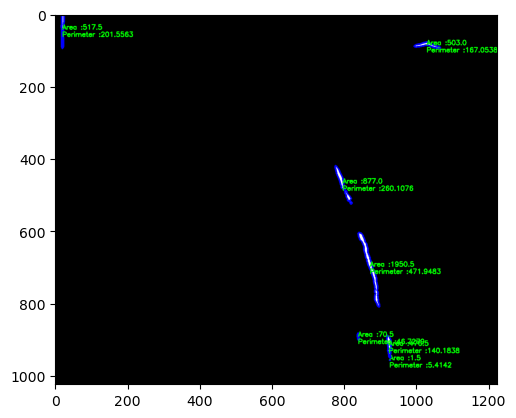

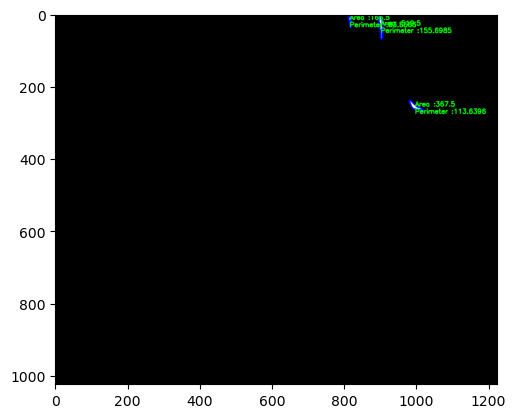

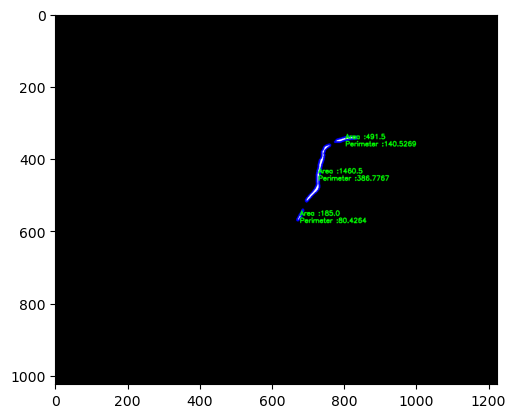

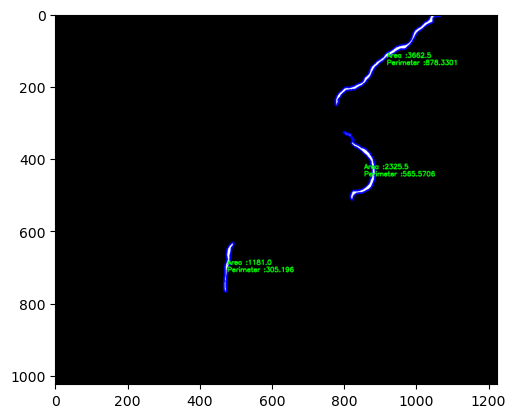

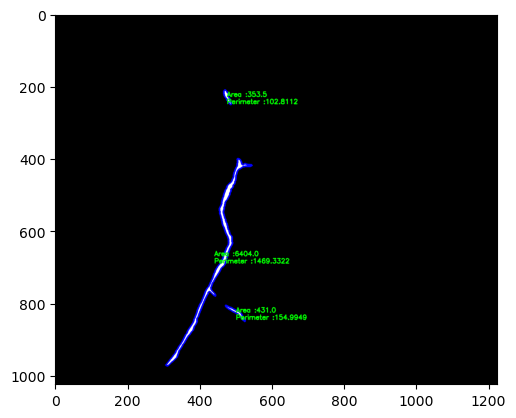

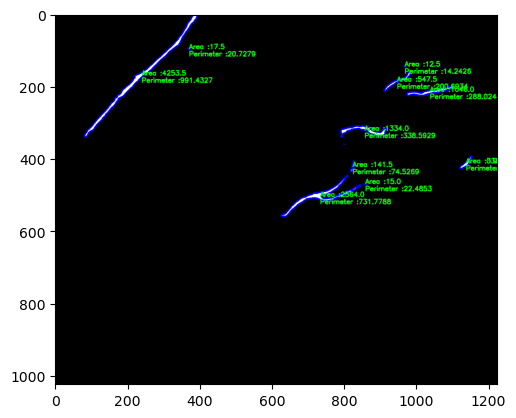

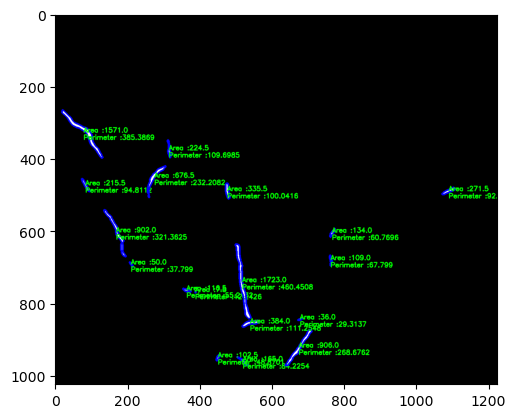

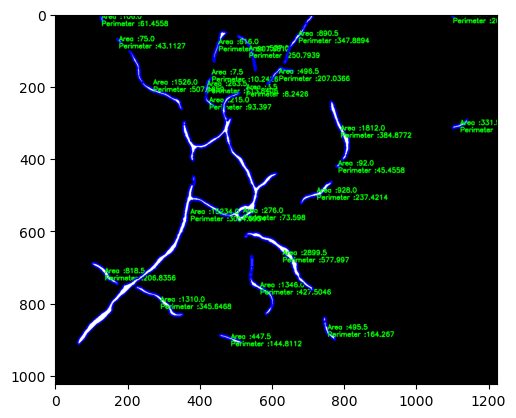

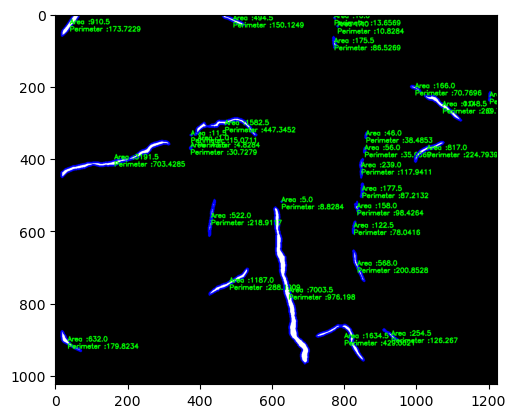

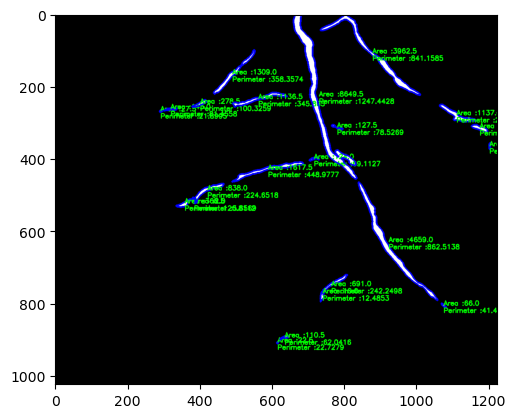

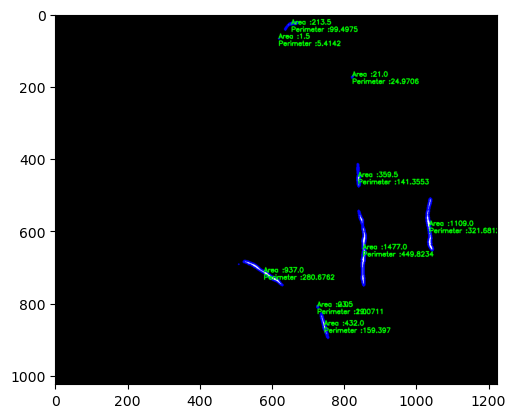

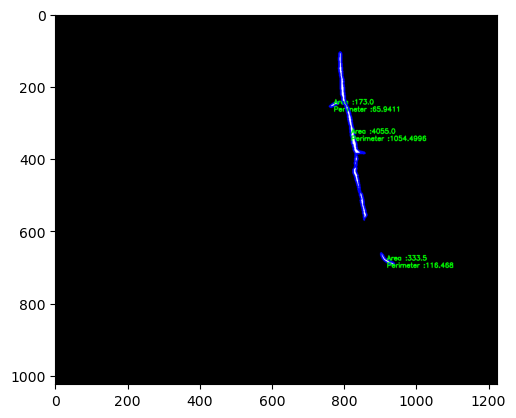

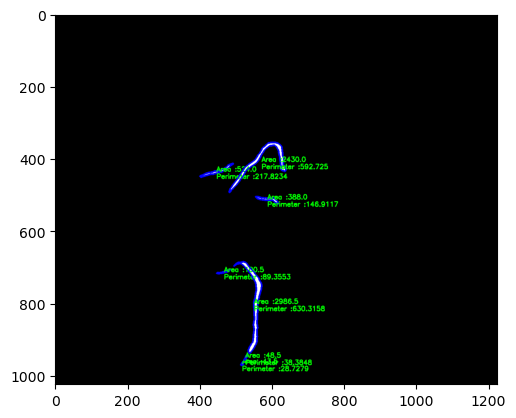

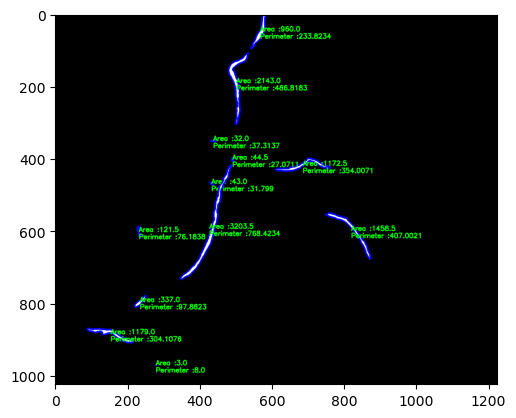

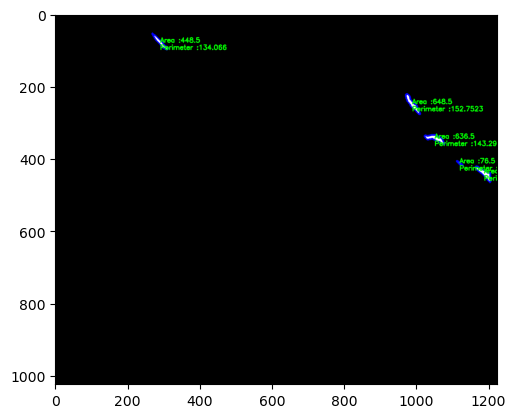

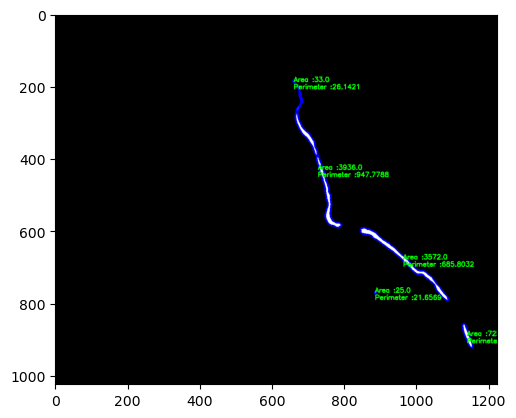

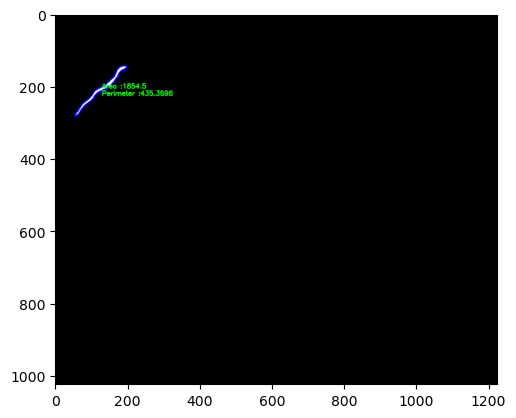

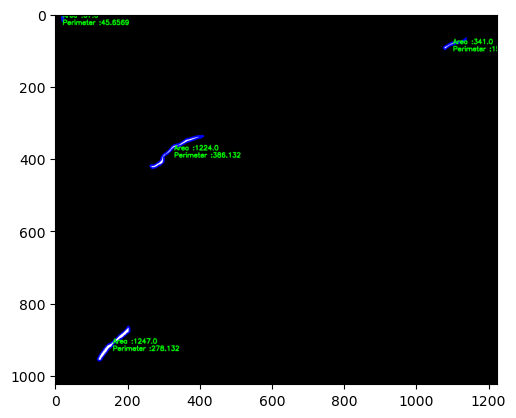

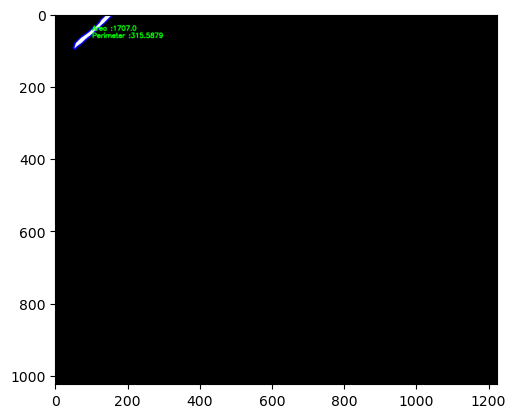

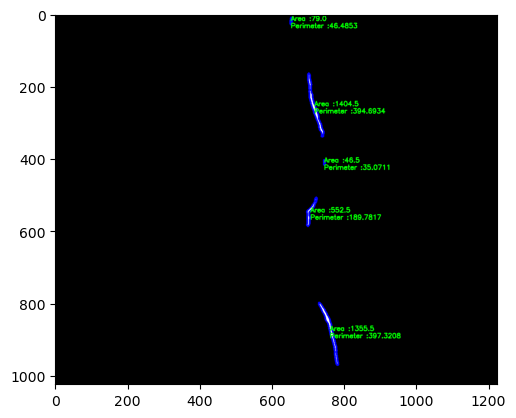

In [8]:
#Data Preparation for Modelling
import pandas as pd
import matplotlib.pyplot as plt
import mahotas.demos
from skimage.morphology import skeletonize
import numpy as np
import cv2
import os
import PIL

def find_thickness(binary_image):
    # Find all contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate the average thickness of all contours
    thickness_sum = 0
    for contour in contours:
        # Calculate the width and height of the bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)
        thickness_sum += min(w, h)
    
    average_thickness = thickness_sum / len(contours) if contours else 0

    return average_thickness



cols = ['Tube', 'position','#contours','TotalArea','Perimeter','pRLD']
data = pd.DataFrame(columns = cols)
for text in sorted(Root_imgs_file_name, key=lambda x: os.path.splitext(x)[0])[0:20]:
    tube_no,position=[int(s) for s in str(text).split("_") if s.isdigit()][0:2] # Extract tube no from file name
    soil_depth=(((position-420)*np.sin((23.5*(np.pi/180)))+570))/10.0 # in cm
    img = cv2.imread(str(text))
    #print(img.shape)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply thresholding in the gray image to create a binary image
    thresh,bi_img = cv2.threshold(gray,150,255,0) # >150 then 255 o/w 0
    
# Find the contours using binary image
    contours,hierarchy = cv2.findContours(bi_img, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

   # print("Number of contours in image:",len(contours))
    totalRootArea=0

    for i, cnt in enumerate(contours):
       M = cv2.moments(cnt)
       if M['m00'] != 0.0:
          x1 = int(M['m10']/M['m00'])
          y1 = int(M['m01']/M['m00'])
       area = cv2.contourArea(cnt)
       totalRootArea+=area
       perimeter = cv2.arcLength(cnt, True)
       perimeter = round(perimeter, 4)
       #print(f'Area of contour {i+1}:', area)
       #print(f'Perimeter of contour {i+1}:', perimeter)
       img1 = cv2.drawContours(img, [cnt], -1, (0,0,255), 3)
       cv2.putText(img1, f'Area :{area}', (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
       cv2.putText(img1, f'Perimeter :{perimeter}', (x1, y1+20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
       bi_img[bi_img==255]=1
       euler = mahotas.euler(bi_img)
       #print("Euler Number of Image : " + str(euler))
    plt.figure()
    plt.imshow(img, cmap='gray')
    skel = skeletonize(bi_img)
    skel = skel.astype(np.int)
    pRLD= np.sum(skel)
    

    data = data.append({'Tube': tube_no,'position': position,'#contours': len(contours),'TotalArea':totalRootArea,'Perimeter':perimeter,'pRLD':pRLD},ignore_index=True)
    cv2.imshow("Image", img)
    print(f'Total Root area:', totalRootArea)
data.to_csv('MorphoFeature_June2018.csv')  

In [9]:
data

,Tube,position,#contours,TotalArea,Perimeter,pRLD
0,100.0,2011.0,7.0,4396.5,201.5563,548.0
1,100.0,2046.0,3.0,1053.5,83.5563,139.0
2,100.0,2081.0,3.0,2137.0,140.5269,245.0
3,100.0,2115.0,3.0,7169.0,878.3301,718.0
4,100.0,2151.0,3.0,7188.5,102.8112,719.0
5,100.0,2186.0,11.0,10270.0,991.4327,1098.0
6,100.0,2221.0,18.0,7930.0,385.3869,1004.0
7,100.0,2255.0,24.0,30765.0,61.4558,3131.0
8,100.0,2291.0,29.0,21237.5,173.7229,2105.0
9,100.0,2325.0,22.0,25766.0,1247.4428,2268.0


In [48]:
data.describe()

,Tube,position,#contours,TotalArea,Perimeter,pRLD
count,21129.000000,21129.000000,21129.000000,21129.000000,21129.000000,21129.000000
mean,152.340338,3254.853803,4.629798,4075.111056,245.269738,399.706138
std,90.249476,726.659172,6.061843,6035.926760,323.237115,568.971710
min,1.000000,1997.000000,0.000000,0.000000,0.000000,0.000000
25%,75.000000,2639.000000,0.000000,0.000000,56.727900,0.000000
50%,154.000000,3269.000000,2.000000,806.500000,140.710700,101.000000
75%,227.000000,3898.000000,8.000000,6401.000000,304.249800,650.000000
max,563.000000,4507.000000,39.000000,51570.500000,5000.731600,5094.000000


***Correlation***

In [47]:
data.loc[:,['#contours','TotalArea','Perimeter','pRLD']].corr()

,#contours,TotalArea,Perimeter,pRLD
#contours,1.000000,0.846856,0.168712,0.893285
TotalArea,0.846856,1.000000,0.350843,0.983961
Perimeter,0.168712,0.350843,1.000000,0.325611
pRLD,0.893285,0.983961,0.325611,1.000000


In [ ]:
import cv2
import numpy as np

def find_thickness_and_display(binary_image):
    # Find all contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate the average thickness of all contours
    thickness_sum = 0
    for contour in contours:
        # Calculate the width and height of the bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)
        thickness_sum += min(w, h)
    
    average_thickness = thickness_sum / len(contours) if contours else 0

    # Display the binary image with the bounding rectangles
    color_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(color_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.imshow("Binary Image with Bounding Rectangles", color_image)
    cv2.waitKey(0)
    
    return average_thickness

# Load a binary image
#binary_image = cv2.imread("binary_image.png", cv2.IMREAD_GRAYSCALE)

# Convert to a binary image
#_, binary_image = cv2.threshold(binary_image, 128, 255, cv2.THRESH_BINARY)

# Find the average thickness of the objects in the binary image and display the corresponding bounding boxes
thickness = find_thickness_and_display(bi_img)

print("The average thickness is", thickness)


In [45]:
  data

,Tube,position,#contours,TotalArea,EulerNumber
0,296.0,2151.0,17.0,13231.0,15.0
1,29.0,3164.0,5.0,3782.0,5.0
2,103.0,3692.0,3.0,914.5,3.0
3,268.0,3622.0,0.0,0.0,3.0
4,205.0,2466.0,0.0,0.0,3.0
5,52.0,3097.0,2.0,109.0,2.0
6,158.0,3095.0,2.0,645.5,2.0
7,76.0,4217.0,0.0,0.0,2.0
8,180.0,4145.0,0.0,0.0,2.0
9,259.0,2151.0,19.0,11466.0,19.0


In [54]:
import cv2
import numpy as np

# Find the average thickness of the objects in the binary image
thickness = find_thickness(bi_img)

print("The average thickness is", thickness)


The average thickness is 28.2


In [21]:
import mahotas

ModuleNotFoundError: No module named 'mahotas'

In [36]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL

# Read the input image
#img = cv2.imread('/Users/trl102/Downloads/Radimax_Cam1_PipeID_100_Position_2572_TS_2018-06-18_14.42.46.240.bdiv.rgb.png')
img = cv2.imread('/Users/trl102/Downloads/Radimax_Cam1_PipeID_100_Position_2151_TS_2018-06-18_14.43.19.874.bdiv.rgb.png')
# convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply thresholding in the gray image to create a binary image
ret,thresh = cv2.threshold(gray,150,255,0)

# Find the contours using binary image
contours,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
print("Number of contours in image:",len(contours))
totalRootArea=0

for i, cnt in enumerate(contours):
   M = cv2.moments(cnt)
   if M['m00'] != 0.0:
      x1 = int(M['m10']/M['m00'])
      y1 = int(M['m01']/M['m00'])
   area = cv2.contourArea(cnt)
   totalRootArea+=area
   perimeter = cv2.arcLength(cnt, True)
   perimeter = round(perimeter, 4)
   print(f'Area of contour {i+1}:', area)
   print(f'Perimeter of contour {i+1}:', perimeter)
   img1 = cv2.drawContours(img, [cnt], -1, (0,0,255), 3)
   cv2.putText(img1, f'Area :{area}', (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
   cv2.putText(img1, f'Perimeter :{perimeter}', (x1, y1+20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
   thresh[thresh==255]=1
   euler = mahotas.euler(thresh )
   print("Euler Number of Image : " + str(euler))

print(f'Total Root area:', totalRootArea)
#cv2.imshow("Image", img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()


Number of contours in image: 3
Area of contour 1: 431.0
Perimeter of contour 1: 154.9949
Euler Number of Image : 3.0
Area of contour 2: 6404.0
Perimeter of contour 2: 1469.3322
Euler Number of Image : 3.0
Area of contour 3: 353.5
Perimeter of contour 3: 102.8112
Euler Number of Image : 3.0
Total Root area: 7188.5


In [35]:
np.unique(thresh)

array([0, 1], dtype=uint8)

In [34]:
thresh[thresh==255]=1

In [31]:
thresh.shape 

(1024, 1224)

PosixPath('/Users/trl102/RadiMax_seg')

In [ ]:
/Users/trl102/RadiMax_seg/Full_experiment_seg